<a href="https://colab.research.google.com/github/MahmoudHabibForsan/MahmoudHabibForsan.github.io/blob/master/Project_2_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Dataset Import

In [1]:
!pip install -q kaggle
from google.colab import files

print("Upload your kaggle.json")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d orvile/annotated-ultrasound-liver-images-dataset
!unzip -q annotated-ultrasound-liver-images-dataset.zip -d liver_data


Upload your kaggle.json


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/orvile/annotated-ultrasound-liver-images-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/67.1M [00:00<?, ?B/s]
100% 67.1M/67.1M [00:00<00:00, 1.24GB/s]


Loading the dataset and imports

In [2]:
!pip install kagglehub --quiet
!pip install opencv-python-headless --quiet

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import kagglehub

In [26]:
import json
from PIL import Image, ImageDraw
import numpy as np

def json_to_mask(json_path, img_size=(256, 256), original_size=(480, 640)):  # adjust original_size based on actual dimensions
    with open(json_path) as f:
        points = json.load(f)

    # Scale all points to match the resized image
    scaled = [(x * img_size[0] / original_size[1], y * img_size[1] / original_size[0]) for x, y in points]

    # Draw the polygon onto a blank mask
    mask = Image.new('L', img_size, 0)
    draw = ImageDraw.Draw(mask)
    draw.polygon(scaled, outline=1, fill=1)

    return np.array(mask)

In [28]:
class LiverDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.transform = transform

        for filename in os.listdir(image_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(image_dir, filename)
                mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.json'))

                if os.path.exists(mask_path):
                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256)) / 255.0
        img = np.expand_dims(img, axis=0)

        mask = json_to_mask(self.mask_paths[idx])
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [29]:
image_dir = '/content/liver_data/7272660/Malignant/Malignant/image'
mask_dir = '/content/liver_data/7272660/Malignant/Malignant/segmentation/liver'
dataset = LiverDataset(image_dir, mask_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [30]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")


Epoch 1, Loss: 0.5551
Epoch 2, Loss: 0.3264
Epoch 3, Loss: 0.2827
Epoch 4, Loss: 0.2752
Epoch 5, Loss: 0.2570
Epoch 6, Loss: 0.2544
Epoch 7, Loss: 0.2481
Epoch 8, Loss: 0.2345
Epoch 9, Loss: 0.2262
Epoch 10, Loss: 0.2366


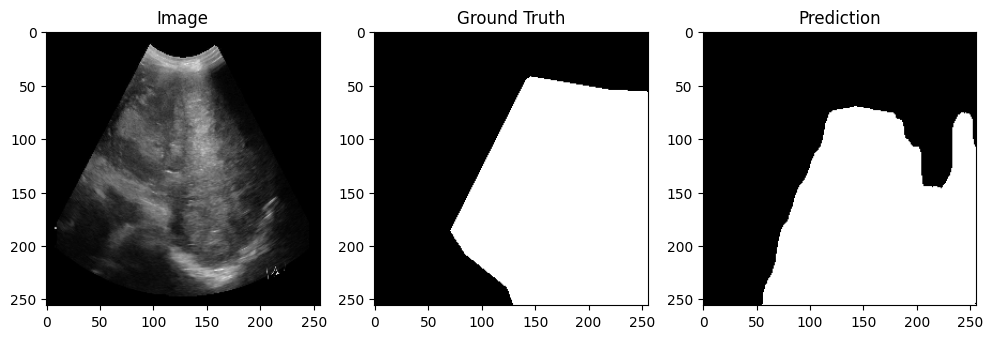

In [32]:
model.eval()
with torch.no_grad():
    sample_img, sample_mask = dataset[0]
    pred = model(sample_img.unsqueeze(0).to(device)).cpu().squeeze().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(sample_img.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(sample_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred > 0.5, cmap='gray')
plt.show()
